In [22]:


# Importing necessary libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
!pip install tpot
from tpot import TPOTClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score

#Importing library for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [23]:

#Filter the unwanted warning
import warnings
warnings.simplefilter("ignore")

In [24]:
train = pd.read_csv("/content/blood-train.csv")
test=pd.read_csv("/content/blood-test.csv")
train.head()

print("Train Shape : ",train.shape)
print("Test Shape : ",test.shape)



Train Shape :  (576, 6)
Test Shape :  (200, 5)


In [25]:
# Print a concise summary of transfusion DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Unnamed: 0                   576 non-null    int64
 1   Months since Last Donation   576 non-null    int64
 2   Number of Donations          576 non-null    int64
 3   Total Volume Donated (c.c.)  576 non-null    int64
 4   Months since First Donation  576 non-null    int64
 5   Made Donation in March 2007  576 non-null    int64
dtypes: int64(6)
memory usage: 27.1 KB


In [5]:
# Rename target column as 'target' for brevity
train.rename(
    columns={'Made Donation in March 2007':'Target'},
    inplace=True
)   


In [6]:

#Counting the number of people who donated and not donated
train["Target"].value_counts()

0    438
1    138
Name: Target, dtype: int64

In [7]:
test.head()

Unnamed: 0  ...  Months since First Donation
0         659  ...                           52
1         276  ...                           38
2         263  ...                            4
3         303  ...                           38
4          83  ...                           34

[5 rows x 5 columns]

In [8]:
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Unnamed: 0                   200 non-null    int64
 1   Months since Last Donation   200 non-null    int64
 2   Number of Donations          200 non-null    int64
 3   Total Volume Donated (c.c.)  200 non-null    int64
 4   Months since First Donation  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


In [9]:

# Statistics of the data
train.describe()


Unnamed: 0  ...      Target
count  576.000000  ...  576.000000
mean   374.034722  ...    0.239583
std    216.947773  ...    0.427200
min      0.000000  ...    0.000000
25%    183.750000  ...    0.000000
50%    375.500000  ...    0.000000
75%    562.500000  ...    0.000000
max    747.000000  ...    1.000000

[8 rows x 6 columns]

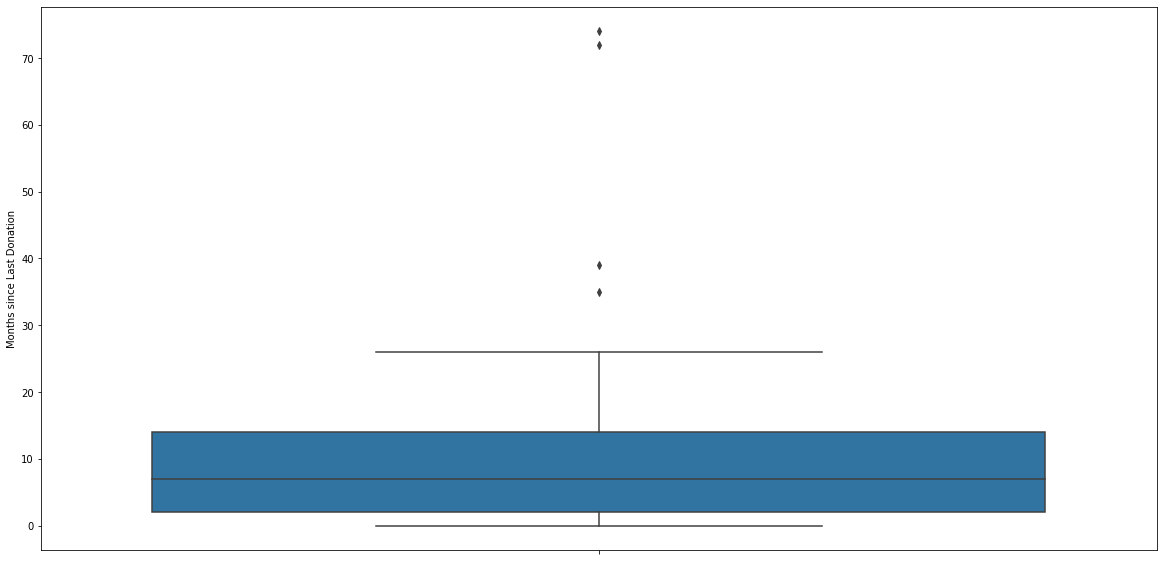

In [10]:

#Boxplot for Months since Last Donation
plt.figure(figsize=(20,10)) 
sns.boxplot(y="Months since Last Donation",data=train)



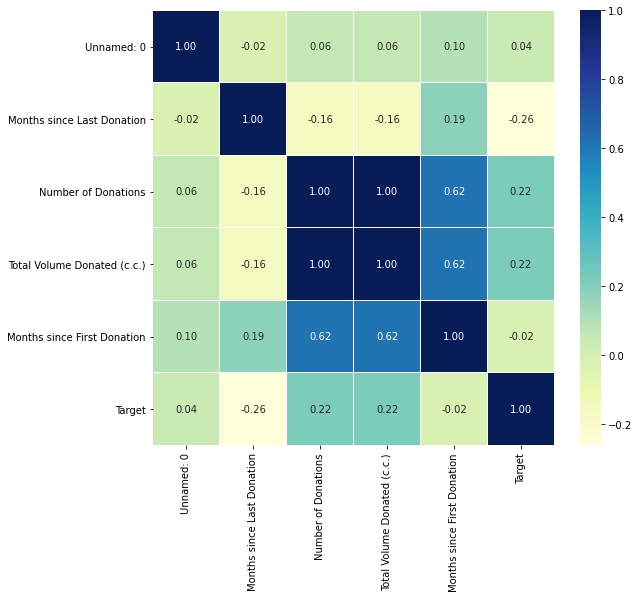

In [11]:

#Correlation between all variables [Checking how different variable are related]
corrmat=train.corr()
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1,fmt = ".2f",annot=True)


In [12]:

# Import train_test_split method
from sklearn.model_selection import train_test_split

# Split transfusion DataFrame into
# X_train, X_test, y_train and y_test datasets,
# stratifying on the `target` column
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns=['Target','Unnamed: 0']),
    train.Target,
    test_size=0.2,
    random_state=0)


In [13]:

    # Import TPOTClassifier and roc_auc_score
# from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)



Generation 1 - Current best internal CV score: 0.7355558350100603

Generation 2 - Current best internal CV score: 0.7355558350100603

Generation 3 - Current best internal CV score: 0.7355558350100603

Generation 4 - Current best internal CV score: 0.7355558350100603

Generation 5 - Current best internal CV score: 0.7441359266711379

Best pipeline: LogisticRegression(GaussianNB(input_matrix), C=25.0, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT light', crossover_rate=0.1, cv=5,
               disable_update_check=True, early_stop=None, generations=5,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=20,
               random_state=42, scoring='roc_auc', subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [14]:

# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')




AUC score: 0.7647


In [15]:

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')



Best pipeline steps:
1. StackingEstimator(estimator=GaussianNB(priors=None, var_smoothing=1e-09))
2. LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [16]:
tpot.fitted_pipeline_


Pipeline(memory=None,
         steps=[('stackingestimator',
                 StackingEstimator(estimator=GaussianNB(priors=None,
                                                        var_smoothing=1e-09))),
                ('logisticregression',
                 LogisticRegression(C=25.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [17]:
# Importing modules
from sklearn.linear_model import LogisticRegression
# Instantiate LogisticRegression
logreg = LogisticRegression(C=25.0, random_state=42)


In [18]:
#Fitting the model
logreg.fit(X_train,y_train)


LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
#Predicting on the test data
pred=logreg.predict(X_test)


In [20]:

#printing the confusion matrix
confusion_matrix(pred,y_test)


array([[80, 29],
       [ 1,  6]])

In [21]:
# AUC score for tpot model
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.8042
